# Step 1: Brief description of the problem and data (5 pts)

https://www.kaggle.com/competitions/histopathologic-cancer-detection/submissions

In this project, our target is to create an modle to identify cancer in histopathological Images.


- There are two datasets, a training and testing. 
- The training set contains 220,025 unique images and the test set contains about 57,500, each image is 96px * 96px with 3 channels.
- Each image in training set have been labeled either a 0 or 1,which means whether the image is cancerous. 
- Finally I will predict the testing set by the model which trained by training set. And send the result to the competition in Kaggle.

# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

- Show the label distribution of training set as histogram.
- Show cancerous and non-cancerous images separately.
- Split the training set into different directories by label (0 or 1) in preparation for image data generator and batch training.

In [1]:
import numpy as np 
import pandas as pd 
import os
import shutil

from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
# read train label data and create image path columns
root_path = 'train/'
train_labels = pd.read_csv('train_labels.csv')

train_labels['path'] = root_path + train_labels['id'] +'.tif'
train_labels['label'] = train_labels['label'].astype(str)
train_labels.head(3)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,train/f38a6374c348f90b587e046aac6079959adf3835...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,train/c18f2d887b7ae4f6742ee445113fa1aef383ed77...
2,755db6279dae599ebb4d39a9123cce439965282d,0,train/755db6279dae599ebb4d39a9123cce439965282d...


<AxesSubplot:>

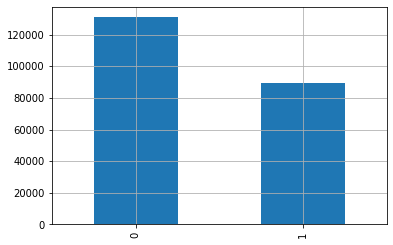

In [8]:
# Show the label distribution of training set as histogram, which is unbalance.
train_labels['label'].value_counts().plot(kind='bar',grid=True)

In [8]:
# show the image shape
image_shape = cv.imread(train_labels['path'].iloc[0]).shape
image_shape

(96, 96, 3)

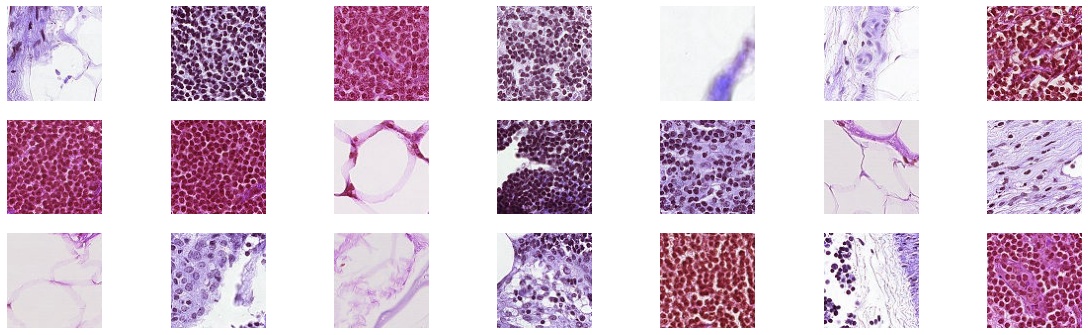

In [9]:
# show non-cancerous images
show_amount = 21
look_df = train_labels[train_labels['label']=='0']
look_df = look_df.iloc[random.sample(list(range(len(look_df))),show_amount)]

plt.figure(figsize=(20, 8))
width =7
height = show_amount // width + 1
for n,i in enumerate(range(show_amount)):
    plt.subplot(height, width, n+1)
    img_np = cv.imread(look_df['path'].iloc[i])
    #plt.title(look_df.index[i])
    plt.axis("off")
    plt.imshow(img_np) 

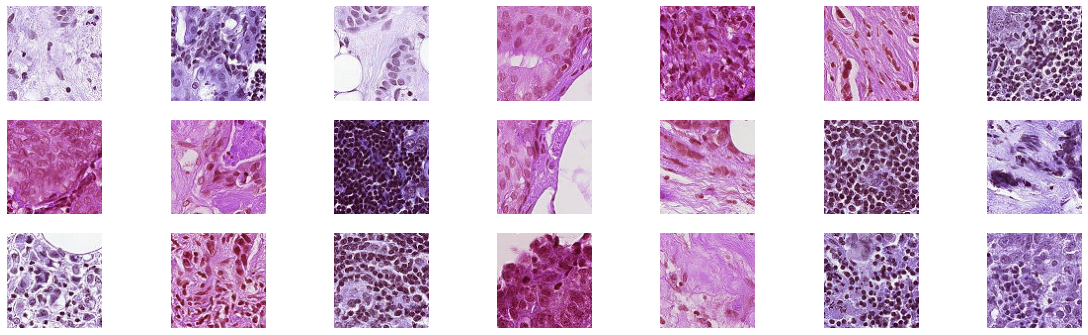

In [10]:
# show cancerous images
show_amount = 21
look_df = train_labels[train_labels['label']=='1']
look_df = look_df.iloc[random.sample(list(range(len(look_df))),show_amount)]

plt.figure(figsize=(20, 8))
width =7
height = show_amount // width + 1
for n,i in enumerate(range(show_amount)):
    plt.subplot(height, width, n+1)
    img_np = cv.imread(look_df['path'].iloc[i])
    #plt.title(look_df.index[i])
    plt.axis("off")
    plt.imshow(img_np)

In [8]:
# Adjust the training set to be balanced.
sample_amount = train_labels['label'].value_counts().min()
train_labels_0 = train_labels[train_labels['label']=='0'][:sample_amount]
train_labels_1 = train_labels[train_labels['label']=='1'][:sample_amount]
train_labels = pd.concat([train_labels_0,train_labels_1])
train_labels['label'].value_counts()

1    89117
0    89117
Name: label, dtype: int64

In [9]:
# Here I split an extra test data to test the model performance before start to predict submission data.
train_labels, test_df = train_test_split(train_labels, test_size=0.10, random_state=42)

### Keras ImageDataGenerator package 
Use ImageDataGenerator for data generate and training in batch : Read pictures in batches, process,generate and train. 

It would be great helpfult when the dataset is large and can not read all the image at once.

In [11]:
# Since the training set is large. I didn't do other data generate here,like horizontal_flip or vertical_flip.
# Generator can will be helpful when we have few labeled data.
from keras.preprocessing.image import ImageDataGenerator
train_datagen  = ImageDataGenerator(rescale=1/255,
                                    validation_split=0.20,
                                    #horizontal_flip =True,
                                    #vertical_flip = True
                                   )

Using TensorFlow backend.


In [11]:
batch_size = 32
image_shape = (64, 64, 3)
target_image_size = image_shape[:2]
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    x_col="path",
    y_col='label',
    subset="training",
    class_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=target_image_size,
    shuffle=True,
    seed=99,
    )

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    x_col="path",
    y_col='label',
    subset="validation",
    class_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=target_image_size,
    shuffle=True,
    seed=99,
    )
test_gen = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    #y_col='label',
    class_mode= None,
    color_mode='rgb',
    batch_size=1,
    target_size=target_image_size,
    shuffle=False,
    )

Found 128328 validated image filenames belonging to 2 classes.
Found 32082 validated image filenames belonging to 2 classes.
Found 17824 validated image filenames.


# Step 3: Model Architecture
My model architexture reference the vgg16 Architecture from Keras:
https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py


Picture form:https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
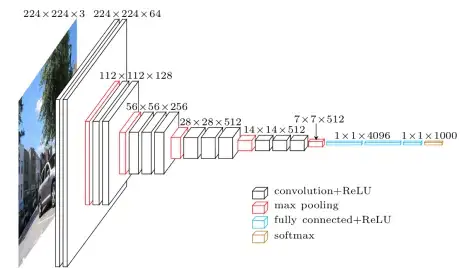


- The first goal for the model architecture should to be as deep as possible but with fewer parameters, which can both have good performance and fewer training time.
- For this porject I tried multiple architectures and tuned hyperparameters. This architecture is the best to balance the two: 

#### Model Architexture :
input(64, 64, 3)

-> [ Conv2D*2 -> MaxPool 2D] x2 (filters = 32, 64)

-> [ Conv2D*3 -> MaxPool 2D] x2 (filters = 128, 256)

-> Flatten 

-> [ Dense (64) ] x3

-> [ Dense (1) ]

-> Out





In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam

kernel_size = (3,3)
pool_size= (2,2)

model = Sequential()
model.add(Conv2D(32, kernel_size, activation = 'relu', input_shape = image_shape,padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size, activation = 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(0.3))


model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.3))

model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)       

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# If val_loss does not decrease in next 5 epochs, Model will stop training.
earlystopper = EarlyStopping(monitor='val_loss',
                             patience=5,
                             verbose=1,
                             restore_best_weights=True)

# Automatically to adjust the learning rate, When val_loss stop decreasing in next 2 epochs, reduce the learning rate.
reducel = ReduceLROnPlateau(monitor='val_loss',
                            patience=2,
                            verbose=1,
                            factor=0.3)
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_gen.n//batch_size,
                              validation_data=val_gen,
                              validation_steps=val_gen.n//batch_size,
                              epochs=30,
                              callbacks=[reducel, earlystopper])

Epoch 1/30
4010/4010 [==============================] - 4936s 1s/step - loss: 0.1754 - accuracy: 0.9338 - val_loss: 0.1595 - val_accuracy: 0.9294
Epoch 2/30
4010/4010 [==============================] - 4589s 1s/step - loss: 0.1713 - accuracy: 0.9350 - val_loss: 0.1067 - val_accuracy: 0.9236
Epoch 3/30
4010/4010 [==============================] - 4589s 1s/step - loss: 0.1691 - accuracy: 0.9357 - val_loss: 0.2449 - val_accuracy: 0.9349
Epoch 4/30
4010/4010 [==============================] - 4589s 1s/step - loss: 0.1637 - accuracy: 0.9379 - val_loss: 0.3346 - val_accuracy: 0.9334

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
Epoch 5/30
4010/4010 [==============================] - 4586s 1s/step - loss: 0.1550 - accuracy: 0.9423 - val_loss: 0.1321 - val_accuracy: 0.9393
Epoch 6/30
4010/4010 [==============================] - 4586s 1s/step - loss: 0.1511 - accuracy: 0.9432 - val_loss: 0.1313 - val_accuracy: 0.9390

Epoch 00006: ReduceLROnPlateau reducing l

KeyboardInterrupt: 

# Step 4: Results and Analysis
- Observing the change of the accuracy of train and validation when the training time increasing. We can found that will be a rise after learning rate decreased. The best model should stop training in the 7 epoch.
- Predict the test data and calculate AUC, accuracy score, and print confusion matrix.
    - AUC: 0.982
    - Accuracy score:0.938
- Predict submission data, Public Score of Kaggle: 0.95 
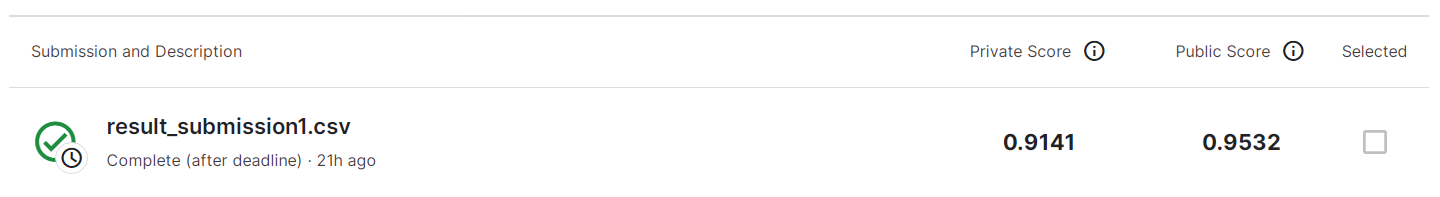

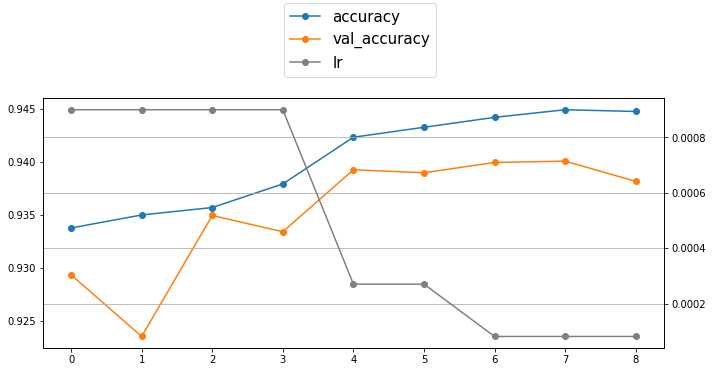

In [23]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.plot(model.history.history['accuracy'],'-o',label ='accuracy' )
ax1.plot(model.history.history['val_accuracy'],'-o',label ='val_accuracy')
ax2.plot(model.history.history['lr'],'-o',label ='lr',color="grey")

fig.legend(bbox_to_anchor=(0.5, 1), loc='lower center', prop={'size': 15})
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix

In [60]:
# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(test_df), verbose=1)

pre_df = pd.DataFrame(y_pred_keras,columns=['pred'])
pre_df.index = [i.replace('train/','').replace('.tif','') for i in test_gen.filenames]
test_df.index = test_df['id'].values

pre_df['label'] = test_df['label'].astype(int)
pre_df['path'] = test_df['path']
pre_df.head()

17824/17824 [==============================] - 196s 11ms/step


,pred,label,path
e041caeea0e452672f94c206f60860380080fe8f,0.996162,1,train/e041caeea0e452672f94c206f60860380080fe8f...
70c3267d1d76d2ec778f9948bccb59687754320e,0.499700,0,train/70c3267d1d76d2ec778f9948bccb59687754320e...
de9368cbd3fd30f1777b5ba0205ade8f2d9f1e75,0.000907,0,train/de9368cbd3fd30f1777b5ba0205ade8f2d9f1e75...
252535bcf7b6857b3eab9b22820ebfffdf14bf95,0.003174,0,train/252535bcf7b6857b3eab9b22820ebfffdf14bf95...
5b85192713585c764705f267d607a1a812819dab,0.719626,1,train/5b85192713585c764705f267d607a1a812819dab...


In [61]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(pre_df['label'], pre_df['pred'])
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.9823550605229319

In [62]:
pre_df['pred_bollin'] = pre_df['pred'].apply(lambda x : 1 if x>0.50 else 0)
accuracy_score(pre_df['label'], pre_df['pred_bollin'])

0.938173249551167

In [22]:
confusion_matrix(pre_df['label'], pre_df['pred_bollin'])

array([[8388,  487],
       [ 615, 8334]], dtype=int64)

### Predict submission data

In [88]:
test_df = pd.read_csv('sample_submission.csv')
test_df['path'] = 'test/'+ test_df['id'] +'.tif'

In [89]:
test_gen = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    #y_col='label',
    class_mode= None,
    color_mode='rgb',
    batch_size=1,
    target_size=target_image_size,
    shuffle=False,
    )

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(test_df), verbose=1)

Found 57458 validated image filenames.
57458/57458 [==============================] - 634s 11ms/step


In [110]:
pre_df = pd.DataFrame(y_pred_keras,columns=['label'])
pre_df['id'] = [i.replace('test/','').replace('.tif','') for i in test_gen.filenames]
pre_df = pre_df[['id','label']]
pre_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.017407
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.283930
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.005885
3,2c35657e312966e9294eac6841726ff3a748febf,0.002705
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.094590


In [115]:
pre_df['label'].apply(lambda x : 0 if x<0.5 else 1).value_counts().plot(kind='bar',grid=True)

0    36432
1    21026
Name: label, dtype: int64

In [117]:
pre_df.to_csv('result_submission1.csv',index=False)

# Step 5: Conclusion

- Processing data with hundreds of thousands of images takes a lot of time. So I first use 5000 images to stucture the cording and model. Observe the predfromace between different Model Architecture. 

- Use ImageDataGenerator for data generate and training in batch : Read pictures in batches, process,generate and train.It would be great helpfult when the dataset is large and can not read all images at once.

- My model architexture reference the vgg16 Architecture from Keras,The first goal for the model architecture should to be as deep as possible but with fewer parameters, which can both have good performance and fewer training time.

- Set model training callback for early stop, and automatically adjust the learning rate.

- Observing the change of the accuracy of train and validation when the training time increasing. We can found that will be a rise after learning rate decreased.

- The Public Score of Kaggle is 0.95 , To get improve, I will tried deeper model architecture and more training time.